In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [2]:
np.random.seed(100)
dataset = np.random.randn(500, 11)
X = dataset[:,0:10].astype("float32")
Y = dataset[:,10].astype("float32")

### Select architecture

In [3]:
# solution 1 -- split single neurons

n_tot = int( X.shape[1] )
splits = int( 2 )
n_splits = int( n_tot/splits )

input = keras.layers.Input(shape = (n_tot), name = "input_layer")
layer1 = keras.layers.Lambda(lambda x: x[:,0:n_splits])(input)  # take the first n_splits neurons
layer2 = keras.layers.Lambda(lambda x: x[:,n_splits:])(input)   # take the other neurons
output1 = keras.layers.Dense(units = 1)(layer1)                 # add extra dense layer
output2 = keras.layers.Dense(units = 1)(layer2)                 # add extra dense layer
output = keras.layers.concatenate([output1, output2])           # concatenate the layers to have a single output layer

model = keras.models.Model(input, output)

In [ ]:
print( model.summary() )

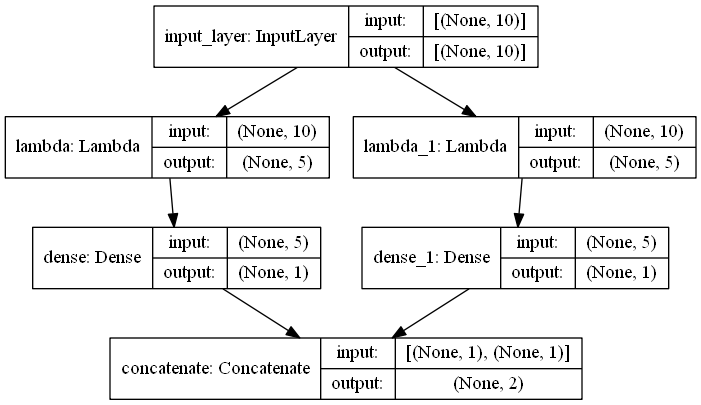

In [4]:
plot_model(model, to_file='model_1.png', show_shapes=True, show_layer_names=True)

In [ ]:
# fit and forecast 
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics=['MeanSquaredError'])
history = model.fit(X, Y, epochs=100)
forecast = model.predict(X)

In [5]:
# solution 2 -- split entire dataset

input = keras.layers.Input(shape=(n_tot), name = "input_layer")
split = keras.layers.Lambda(lambda x: tf.split(x,num_or_size_splits = splits,axis = 1))(input)
layer1 = keras.layers.Dense(units = 1)(split[0])
layer2 = keras.layers.Dense(units = 1)(split[1])
output = keras.layers.concatenate([layer1, layer2])

model = keras.models.Model(input, output)

In [ ]:
print( model.summary() )

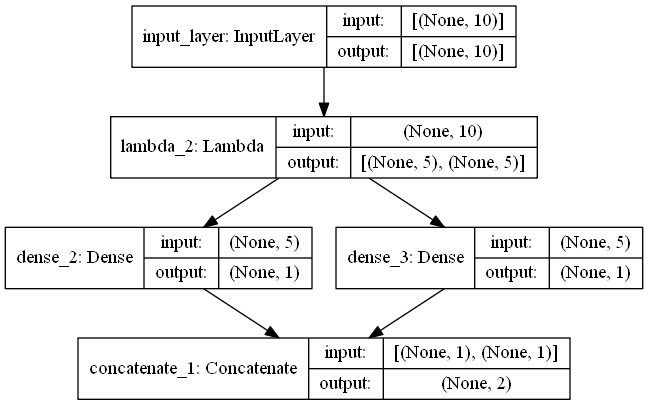

In [6]:
plot_model(model, to_file='model_2.png', show_shapes=True, show_layer_names=True)

In [ ]:
# fit and forecast 
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics=['MeanSquaredError'])
history = model.fit(X, Y, epochs=100)
forecast = model.predict(X)

In [7]:
# solution 3 -- separate inputs 
input_1 = keras.layers.Input(shape=(n_splits,))
input_2 = keras.layers.Input(shape=(n_splits,))
layer_1 = keras.layers.Dense(units = 1)(input_1)
layer_2 = keras.layers.Dense(units = 1)(input_2)
output = keras.layers.Add()([layer_1, layer_2])

model = keras.models.Model(inputs=[input_1,input_2], outputs=output)

In [ ]:
print( model.summary() )

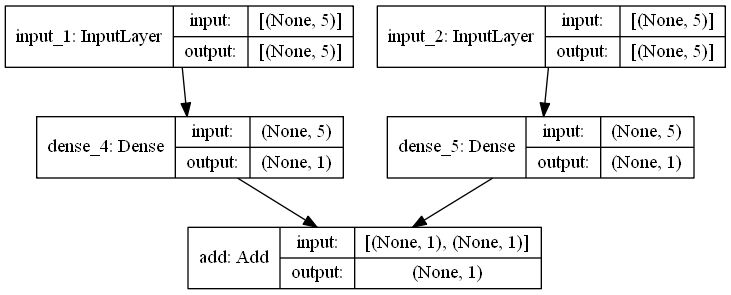

In [8]:
plot_model(model, to_file='model_2.png', show_shapes=True, show_layer_names=True)

In [ ]:
# fit and forecast 
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics=['MeanSquaredError'])
XX = (X[:, :n_splits], X[:, n_splits:])
history = model.fit(XX, Y, epochs=100)
forecast = model.predict(XX)